In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import sklearn

from npDoseResponseDR import DRCurve
from npDoseResponseDerivDR import DRDerivCurve, NeurNet, DRDRDerivBC
import sys
import pickle

import Supplement

In [2]:
data = pd.read_csv('./job_corps.csv', index_col=0)
data = data.sample(frac=1, random_state=20)

data = pd.concat([data.select_dtypes(exclude='int64'),
                  pd.get_dummies(data.select_dtypes('int64').astype('category'),
                                 drop_first=True).astype('int64')],
                 axis=1)
X = data.drop(['d','y'], axis=1).values #define covariate vector, excluding T and Y
T = data['d'].values # define treatment vector
Y = data['y'].values # define outcome vector

In [3]:
df = pd.read_csv('./job_corps.csv', index_col=0)
df.columns

Index(['y', 'd', 'female', 'age', 'race_white', 'race_black', 'race_hispanic',
       'hgrd', 'hgrdmissdum', 'educ_geddiploma', 'educ_hsdiploma', 'ntv_engl',
       'marstat_divorced', 'marstat_separated', 'marstat_livetogunm',
       'marstat_married', 'haschldY0', 'everwkd', 'mwearn', 'hohhd0',
       'peopleathome', 'peopleathomemissdum', 'nonres', 'work_dad_didnotwork',
       'g7', 'welfare_child', 'welfare_childmissdum', 'h1_fair_poor', 'h2',
       'h10', 'h10missdum', 'h5', 'h5missdum', 'h7', 'h7missdum', 'i1', 'i10',
       'e12', 'e12missdum', 'e16', 'e16missdum', 'e21', 'e30', 'e30missdum',
       'e31', 'e32', 'e35', 'e35missdum', 'e37', 'e6_byphone', 'e9ef'],
      dtype='object')

## Replicate the Setups and Methods in Colangelo and Lee 2020

In [4]:
model_nn1 = Supplement.NeuralNet1_emp_app(k=139,
                                          lr=0.15,
                                          momentum=0.9,
                                          epochs=100,
                                          weight_decay=0.05)

model_nn2 = Supplement.NeuralNet2_emp_app(k=138,
                                          lr=0.05, 
                                          momentum=0.3,
                                          epochs=100,
                                          weight_decay=0.15)

model_knn1 = Supplement.NeuralNet1k_emp_app(k=138,
                                          lr=0.15,
                                          momentum=0.9,
                                          epochs=100,
                                          weight_decay=0.05)

model_knn2 = Supplement.NeuralNet2_emp_app(k=138,
                                          lr=0.05, 
                                          momentum=0.3,
                                          epochs=100,
                                          weight_decay=0.15)

### L=5

In [ ]:
# Set of all t we will evaluate at. We start at t=160 as the estimator performs
# poorly at the boundary (in general we recommend to avoid the boundary points).
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)
t_list = t_list_new
h = np.std(T)*3*(len(Y)**(-0.2)) # Initial rule of thumb bandwidth choice
# We use both the rule of thumb bandwidth, and double it, as we need to compute
# the estimator at two bandwidths in order to estimate the optimal bandwidth. 
h = 2*h 
L = 5 # Number of folds for cross-fitting
col_names = ['t','beta','se','h_star','h'] # names for everything we store from the estimation
u = 0.5 #Defines the multiple of the previous "h" that is used as a second bandwidth.

ml_list = ['nn','knn'] # ml methods to be used.
# We first iterate over every method, estimating for bandwidth 2*h
# where h is chosen as a rule of thumb bandwidth 3*std(T)*N^(-0.2).
# We use the estimates from these two bandwidth choices and apply
# the optimal bandwidth estimator in Colangelo and Lee (2022) to obtain
# the final optimal bandwidth. The second loop then iterates over all ML
# methods and uses the optimal bandwidth. 
for ml in ml_list:
    if ml == 'knn':
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    else:
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.DDMLCT(model_nn1, model_nn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    
    # We compute h_star based on the formulas from our paper, utilizing output
    # from this first round of estimation.
    Bt = (model.beta-model2.beta)/((model.h**2)*(1-(u**2)))
    h_star = np.mean(((model2.Vt/(4*(Bt**2)))**0.2)*(model.n**-0.2))

    # Combine different outputs we wish to store and save to excel. We do not
    # compute theta_hat here, but in another file later "partial_effects.py"
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path + name
    output.to_excel(file)

In [ ]:
L = 5
# Carry out the estimation a second time, this time using the computed h*
for ml in ml_list:
    # First read h_star from the output files of the first round estimation
    path = './Results/'
    name ='emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path+name
    dat = pd.read_excel(file)
    h = dat['h_star'][0]  
    h = (0.8*h)
    
    # Refit models with new h_star
    if ml=='knn':
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    else:
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(model.h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    output.to_excel(file)

In [ ]:
# This function shifts the vector of estimates so we can take differences
# between estimates at two different t's.
def shift(xs, gap):
    e = np.empty_like(xs)
    if gap >= 0:
        e[:gap] = np.nan
        e[gap:] = xs[:-gap]
    else:
        e[gap:] = np.nan
        e[:gap] = xs[-gap:]
    return e

# the first loop computes estimates under optimal bandwidth. The second loop
# computes estimates under rule of thumb bandwidth.
ml_list = ['nn','knn']
gap = 4
eta = 40*gap
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])
    dat.to_excel(file,index=False)


for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])

    dat.to_excel(file,index=False)

### L=1

In [ ]:
# Set of all t we will evaluate at. We start at t=160 as the estimator performs
# poorly at the boundary (in general we recommend to avoid the boundary points).
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)
t_list = t_list_new
h = np.std(T)*3*(len(Y)**(-0.2)) # Initial rule of thumb bandwidth choice
# We use both the rule of thumb bandwidth, and double it, as we need to compute
# the estimator at two bandwidths in order to estimate the optimal bandwidth. 
h = 2*h 
L = 1 # Number of folds for cross-fitting
col_names = ['t','beta','se','h_star','h'] # names for everything we store from the estimation
u = 0.5 #Defines the multiple of the previous "h" that is used as a second bandwidth.

ml_list = ['nn','knn'] # ml methods to be used.
# We first iterate over every method, estimating for bandwidth 2*h
# where h is chosen as a rule of thumb bandwidth 3*std(T)*N^(-0.2).
# We use the estimates from these two bandwidth choices and apply
# the optimal bandwidth estimator in Colangelo and Lee (2022) to obtain
# the final optimal bandwidth. The second loop then iterates over all ML
# methods and uses the optimal bandwidth. 
for ml in ml_list:
    if ml == 'knn':
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    else:
        # Fit model using 2*(rule of thumb bandwidth)
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
        
        # Fit model using rule of thumb bandwidth.
        model2 = Supplement.DDMLCT(model_nn1, model_nn2)
        model2.fit(X, T, Y, t_list, L, h=h*u, basis=False, standardize=True)
    
    # We compute h_star based on the formulas from our paper, utilizing output
    # from this first round of estimation.
    Bt = (model.beta-model2.beta)/((model.h**2)*(1-(u**2)))
    h_star = np.mean(((model2.Vt/(4*(Bt**2)))**0.2)*(model.n**-0.2))

    # Combine different outputs we wish to store and save to excel. We do not
    # compute theta_hat here, but in another file later "partial_effects.py"
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1.xlsx'
    file = path + name
    output.to_excel(file)

In [ ]:
L = 1
# Carry out the estimation a second time, this time using the computed h*
for ml in ml_list:
    # First read h_star from the output files of the first round estimation
    path = './Results/'
    name ='emp_app_' + str(ml) + '_c3_L5.xlsx'
    file = path+name
    dat = pd.read_excel(file)
    h = dat['h_star'][0]  
    h = (0.8*h)
    
    # Refit models with new h_star
    if ml=='knn':
        model = Supplement.NN_DDMLCT(model_knn1, model_knn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    else:
        model = Supplement.DDMLCT(model_nn1, model_nn2)
        model.fit(X, T, Y, t_list, L, h=h, basis=False, standardize=True)
    
    output = np.column_stack((np.array(t_list),model.beta,model.std_errors,
                                 np.repeat(model.h_star,len(t_list)),
                                 np.repeat(model.h,len(t_list))))
    output = pd.DataFrame(output,columns=col_names)
    
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1_hstar.xlsx'
    file = path + name
    output.to_excel(file)

In [ ]:
# This function shifts the vector of estimates so we can take differences
# between estimates at two different t's.
def shift(xs, gap):
    e = np.empty_like(xs)
    if gap >= 0:
        e[:gap] = np.nan
        e[gap:] = xs[:-gap]
    else:
        e[gap:] = np.nan
        e[:gap] = xs[-gap:]
    return e

# the first loop computes estimates under optimal bandwidth. The second loop
# computes estimates under rule of thumb bandwidth.
ml_list = ['nn','knn']
gap = 4
eta = 40*gap
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])
    dat.to_excel(file,index=False)


for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L1.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    h = dat['h'][0]
    dat['partial effect'] = (shift(dat['beta'],-gap)-shift(dat['beta'],gap))/eta
    dat['se partial effect'] = ((np.sqrt(15/6)/h)*dat['se'])

    dat.to_excel(file,index=False)

## Our proposed estimators

In [5]:
# Evaluation points
t_list = np.arange(160, 2001, 40) 
t_list_new = np.arange(40, 4001, 40)

# Standardize the data as in Colangelo and Lee 2020
dat = np.column_stack([Y,T,X])
dat = sklearn.preprocessing.StandardScaler().fit_transform(pd.DataFrame(dat))
Y_new = dat[:,0]
X_dat = dat[:,1:]
t_qry = (t_list_new - np.mean(T))/np.std(T)

In [ ]:
lr = 0.1
h1 = 223/np.std(T)

# m_est_dr1, sd_est_dr1 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='reg', condTS_mod=model_nn2,
#                             tau=0.001, L=1, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

# m_est_dr5, sd_est_dr5 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
#                             mu=model_nn1, condTS_type='reg', condTS_mod=model_nn2,
#                             tau=0.001, L=5, h=h1, kern="epanechnikov", h_cond=None,
#                             print_bw=False, bnd_cor=False)

theta_dr5, theta_sd5 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
                                beta_mod=NeurNet, n_iter=1000, 
                                lr=lr, condTS_type='reg', condTS_mod=model_nn2, 
                                tau=0.001, L=5, h=h1, kern="epanechnikov", 
                                h_cond=None, print_bw=True, delta=0.01, self_norm=True)

theta_dr1, theta_sd1 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="DR", 
                                beta_mod=NeurNet, n_iter=1000, 
                                lr=lr, condTS_type='reg', condTS_mod=model_nn2, 
                                tau=0.001, L=1, h=h1, kern="epanechnikov", 
                                h_cond=None, print_bw=True, delta=0.01, self_norm=True)

In [ ]:
m_est_ra5 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", mu=model_nn1, 
                    L=5, h=None, kern="epanechnikov", print_bw=False)
m_est_ra1 = DRCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", mu=model_nn1, 
                    L=1, h=None, kern="epanechnikov", print_bw=False)

theta_ra5 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                n_iter=1000, lr=0.1, L=5, print_bw=False, delta=0.01)

theta_ra1 = DRDerivCurve(Y=Y_new, X=X_dat, t_eval=t_qry, est="RA", beta_mod=NeurNet, 
                n_iter=1000, lr=0.1, L=1, print_bw=False, delta=0.01)

# with open('./Syn_Results/Job_Corps_est_lr_'+str(0.1)+'_final1.dat', "wb") as file:
#     pickle.dump([m_est_ra5, m_est_ra1, theta_ra5, theta_ra1, m_est_dr5, sd_est_dr5,
#     m_est_dr1, sd_est_dr1, theta_dr5, theta_sd5, theta_dr1, theta_sd1], file)

In [16]:
# lr = 0.1
# h1 = 223/np.std(T)

# theta_C_DR1, theta_C_sd1 = DRDRDerivBC(Y=Y_new, X=X_dat, t_eval=t_qry, mu=NeurNet, L=1, 
#                                        h=h1, kern='epanechnikov', n_iter=1000, lr=lr, 
#                                        b=None, thres_val=0.5, self_norm=True)
# theta_C_DR5, theta_C_sd5 = DRDRDerivBC(Y=Y_new, X=X_dat, t_eval=t_qry, mu=NeurNet, 
#                                        L=5, h=h1, kern='epanechnikov', n_iter=1000, lr=lr, 
#                                        b=None, thres_val=0.3, self_norm=True)

In [18]:
with open('./Syn_Results/Job_Corps_est_lr_'+str(0.1)+'_final1.dat', "rb") as file:
    m_est_ra5, m_est_ra1, theta_ra5, theta_ra1, m_est_dr5, sd_est_dr5,\
    m_est_dr1, sd_est_dr1, theta_dr5, theta_sd5, theta_dr1, theta_sd1 = pickle.load(file)

### Derivative of Dose-Response Curve

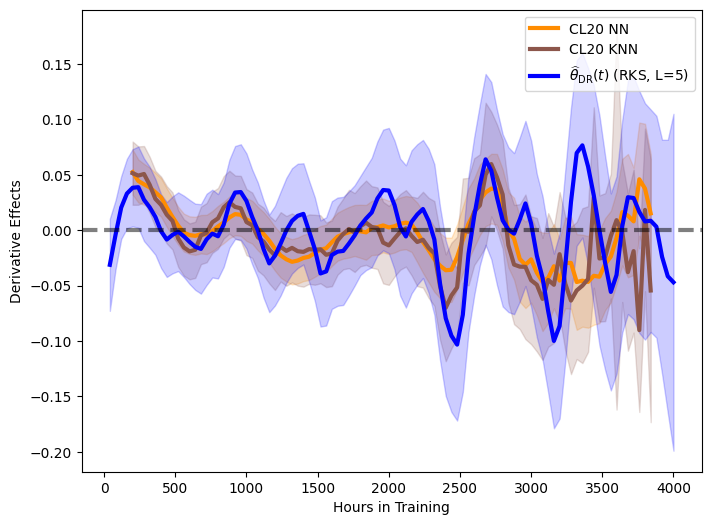

In [19]:
cor_fac = np.std(Y) / np.std(T)
t_list_new = np.arange(40, 4001, 40)

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,6))
ml_list = ['nn', 'knn']
col_lst = {'nn': 'darkorange', 'knn': 'tab:brown'}
name_lst = {'nn': 'NN', 'knn': 'KNN'}
for ml in ml_list:
    path = './Results/'
    name = 'emp_app_' + str(ml) + '_c3_L5_hstar.xlsx'
    file = path + name
    dat = pd.read_excel(file)
    plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 '+str(name_lst[ml]), color=col_lst[ml])
    plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                     dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                     alpha=.2, color=col_lst[ml])

# plt.plot(t_list_new, theta_ra5*cor_fac, color='red', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$ (L=5)')    
# plt.plot(t_list_new, theta_ra1*cor_fac, color='purple', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{RA}}(t)$ (L=1)')

# plt.plot(t_list_new, theta_kde_dr5*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=5)')
# plt.fill_between(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)

plt.plot(t_list_new, theta_dr5*cor_fac, color='blue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=5)')
plt.fill_between(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='blue', alpha=.2)

# plt.plot(t_list_new, theta_dr1*cor_fac, color='darkgreen', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=1)')
# plt.fill_between(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='darkgreen', alpha=.2)

plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
plt.xlabel('Hours in Training')
plt.ylabel('Derivative Effects')
plt.legend()
plt.show()

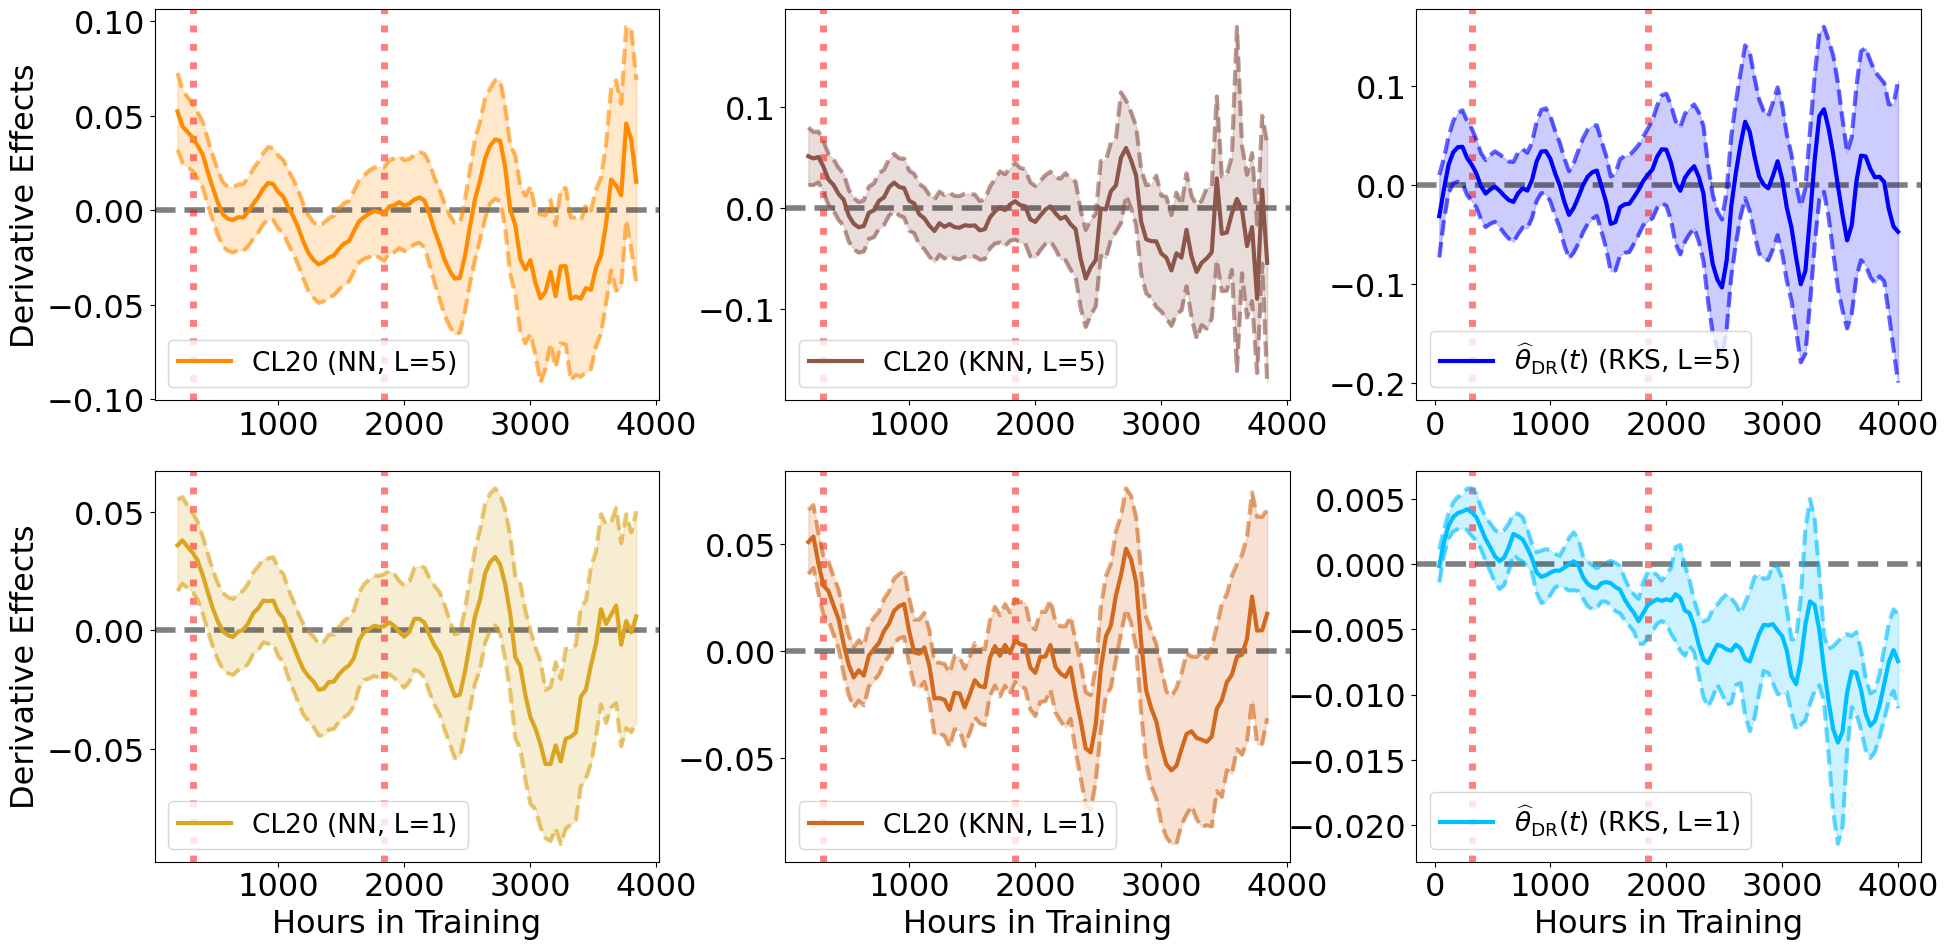

In [20]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=5)', color='darkorange')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='darkorange')
plt.ylabel('Derivative Effects')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 2)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=5)', color='tab:brown')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='tab:brown')
plt.legend(loc='lower left', fontsize=19)


# plt.subplot(2, 4, 3)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=5)')
# plt.plot(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.fill_between(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)
# plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
# plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 3)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr5*cor_fac, color='blue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=5)')
plt.plot(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='blue', alpha=.2)
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 4)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=1)', color='goldenrod')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='goldenrod')
plt.xlabel('Hours in Training')
plt.ylabel('Derivative Effects')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 5)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=1)', color='chocolate')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='chocolate')
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)


# plt.subplot(2, 4, 7)
# plt.plot(t_list_new, theta_kde_dr1*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=1)')
# plt.plot(t_list_new, theta_kde_dr1*cor_fac - theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.plot(t_list_new, theta_kde_dr1*cor_fac + theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.fill_between(t_list_new, theta_kde_dr1*cor_fac - theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr1*cor_fac + theta_kde_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)
# plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
# plt.xlabel('Hours in Training')
# plt.legend(loc='lower left', fontsize=19)


plt.subplot(2, 3, 6)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr1*cor_fac, color='deepskyblue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=1)')
plt.plot(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='deepskyblue', alpha=.2)
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.18)
plt.savefig('./Figures/job_corps_app.pdf')

In [9]:
t_list_new[theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975) < 0]

array([1480, 1520, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040,
       2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560,
       2600, 2640, 2680, 2720, 2880, 3000, 3040, 3080, 3120, 3160, 3320,
       3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760,
       3800, 3840, 3880, 3920, 3960, 4000])

In [10]:
t_list_new[theta_dr1*cor_fac > 0]

array([  40,   80,  120,  160,  200,  240,  280,  320,  360,  400,  440,
        480,  520,  560,  600,  640,  680,  720,  760,  800,  840,  880,
        920,  960, 1000, 1040, 1280, 1320, 1360])

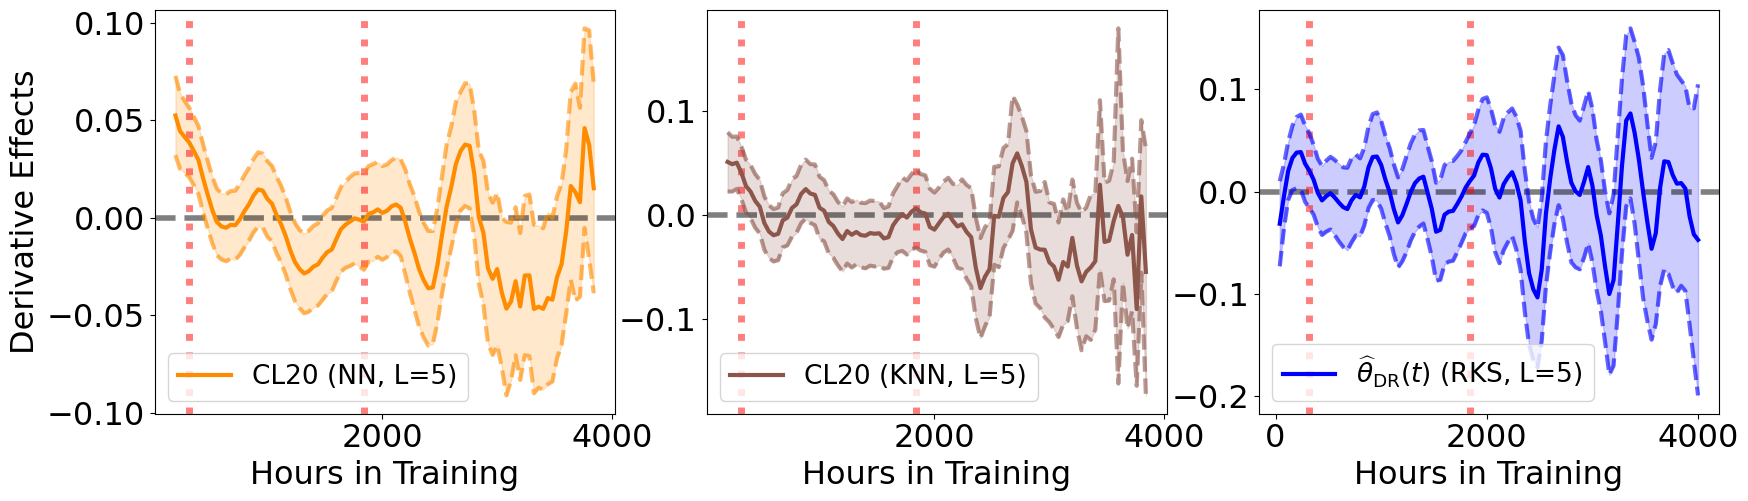

In [21]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(18, 5.5))

plt.subplot(1, 3, 1)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=5)', color='darkorange')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='darkorange', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='darkorange')
plt.ylabel('Derivative Effects')
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(1, 3, 2)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L5_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=5)', color='tab:brown')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='tab:brown', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='tab:brown')
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)


# plt.subplot(2, 4, 3)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac, color='green', linewidth=3, 
#          label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (KDE, L=5)')
# plt.plot(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.plot(t_list_new, theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#          color='green', linewidth=3, linestyle='dashed', alpha=0.6)
# plt.fill_between(t_list_new, theta_kde_dr5*cor_fac - theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
#                  theta_kde_dr5*cor_fac + theta_kde_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='green', alpha=.2)
# plt.axhline(y=0, color='black', linestyle='dashed', linewidth=3, alpha=0.5)
# plt.legend(loc='lower left', fontsize=19)


plt.subplot(1, 3, 3)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr5*cor_fac, color='blue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=5)')
plt.plot(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='blue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr5*cor_fac - theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr5*cor_fac + theta_sd5*cor_fac*scipy.stats.norm.ppf(0.975), color='blue', alpha=.2)
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.18)
plt.savefig('./Figures/job_corps_app_L5.pdf')

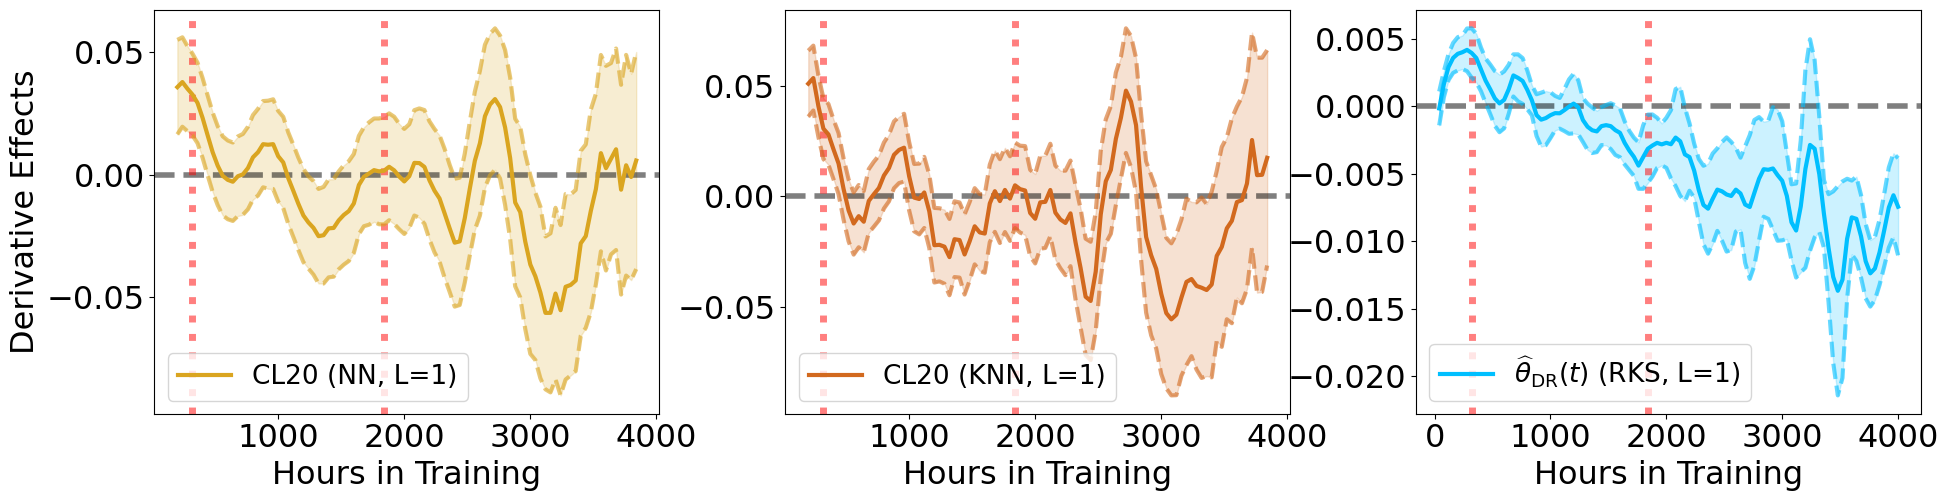

In [24]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(20, 5.5))

plt.subplot(1, 3, 1)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_nn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (NN, L=1)', color='goldenrod')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='goldenrod', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='goldenrod')
plt.xlabel('Hours in Training')
plt.ylabel('Derivative Effects')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(1, 3, 2)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
dat = pd.read_excel('./Results/emp_app_knn_c3_L1_hstar.xlsx')
plt.plot(dat['t'], dat['partial effect'], linewidth=3, label='CL20 (KNN, L=1)', color='chocolate')
plt.plot(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.plot(dat['t'], dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
         linewidth=3, linestyle='dashed', color='chocolate', alpha=0.6)
plt.fill_between(dat['t'], dat['partial effect'] - dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 dat['partial effect'] + dat['se partial effect']*scipy.stats.norm.ppf(0.975), 
                 alpha=.2, color='chocolate')
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)


plt.subplot(1, 3, 3)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=4, alpha=0.5)
plt.axvline(x=320, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.axvline(x=1840, color='red', linestyle='dotted', linewidth=5, alpha=0.5)
plt.plot(t_list_new, theta_dr1*cor_fac, color='deepskyblue', linewidth=3, 
         label=r'$\widehat{\theta}_{\mathrm{DR}}(t)$ (RKS, L=1)')
plt.plot(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.plot(t_list_new, theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
         color='deepskyblue', linewidth=3, linestyle='dashed', alpha=0.6)
plt.fill_between(t_list_new, theta_dr1*cor_fac - theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), 
                 theta_dr1*cor_fac + theta_sd1*cor_fac*scipy.stats.norm.ppf(0.975), color='deepskyblue', alpha=.2)
plt.xlabel('Hours in Training')
plt.legend(loc='lower left', fontsize=19)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.18)
plt.savefig('./Figures/job_corps_app_L1.pdf')